In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import tree,svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Umang-19/devjam/main/public/mldata.csv')
df.head()

,Logical quotient rating,hackathons,coding skills rating,public speaking points,self-learning capability?,Extra-courses did,certifications,workshops,reading and writing skills,memory capability score,Interested subjects,interested career area,Type of company want to settle in?,Taken inputs from seniors or elders,Interested Type of Books,Management or Technical,hard/smart worker,worked in teams ever?,Introvert,Suggested Job Role
0,5,0,6,2,yes,no,information security,testing,poor,poor,programming,testing,BPA,no,Series,Management,smart worker,yes,no,Applications Developer
1,7,6,4,3,no,yes,shell programming,testing,excellent,medium,Management,system developer,Cloud Services,yes,Autobiographies,Technical,hard worker,no,yes,Applications Developer
2,2,3,9,1,no,yes,information security,testing,excellent,poor,data engineering,Business process analyst,product development,yes,Travel,Technical,smart worker,no,no,Applications Developer
3,2,6,3,5,no,yes,r programming,database security,excellent,poor,networks,testing,Testing and Maintainance Services,yes,Guide,Management,smart worker,yes,yes,Applications Developer
4,2,0,3,4,yes,no,distro making,game development,excellent,medium,Software Engineering,system developer,BPA,no,Health,Technical,hard worker,yes,no,Applications Developer


In [3]:
df.info() #Observation: No missing values.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6901 entries, 0 to 6900
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Logical quotient rating              6901 non-null   int64 
 1   hackathons                           6901 non-null   int64 
 2   coding skills rating                 6901 non-null   int64 
 3   public speaking points               6901 non-null   int64 
 4   self-learning capability?            6901 non-null   object
 5   Extra-courses did                    6901 non-null   object
 6   certifications                       6901 non-null   object
 7   workshops                            6901 non-null   object
 8   reading and writing skills           6901 non-null   object
 9   memory capability score              6901 non-null   object
 10  Interested subjects                  6901 non-null   object
 11  interested career area               6901 n

In [4]:
df.describe()

,Logical quotient rating,hackathons,coding skills rating,public speaking points
count,6901.000000,6901.000000,6901.000000,6901.000000
mean,4.991016,2.999710,5.010723,4.988263
std,2.577704,2.010191,2.568347,2.599500
min,1.000000,0.000000,1.000000,1.000000
25%,3.000000,1.000000,3.000000,3.000000
50%,5.000000,3.000000,5.000000,5.000000
75%,7.000000,5.000000,7.000000,7.000000
max,9.000000,6.000000,9.000000,9.000000


In [5]:
df_numeric = df.select_dtypes(include=np.number).columns.tolist()
print("List of Numerical features: \n" , df_numeric)

List of Numerical features: 
 ['Logical quotient rating', 'hackathons', 'coding skills rating', 'public speaking points']


<AxesSubplot:>

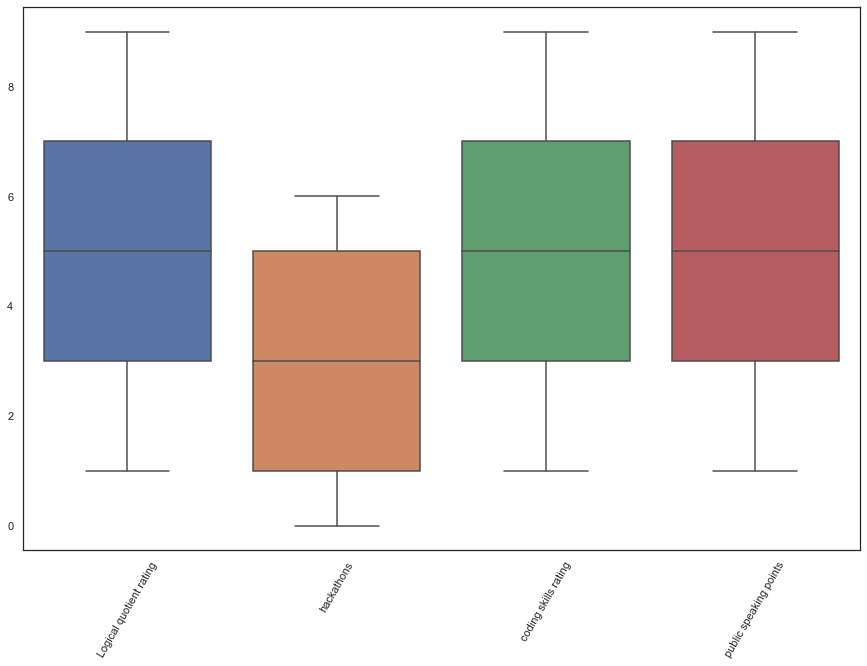

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
sns.boxplot(data=df[df_numeric], ax=ax)

<AxesSubplot:>

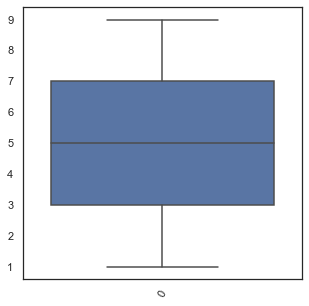

In [7]:
#I checked the Logical quotient rating column for outliers.
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
sns.boxplot(data=df["Logical quotient rating"], ax=ax)

In [8]:
Q1 = df["Logical quotient rating"].quantile(0.25)
Q3 = df["Logical quotient rating"].quantile(0.75)
IQR = Q3-Q1
low_lim = Q1- 1.5*IQR
up_lim = Q3 + 1.5*IQR
outlier = ((df["Logical quotient rating"]<low_lim) | (df["Logical quotient rating"]>up_lim))

In [9]:
df["Logical quotient rating"][outlier] #This column hasn't any outlier

Series([], Name: Logical quotient rating, dtype: int64)

<AxesSubplot:>

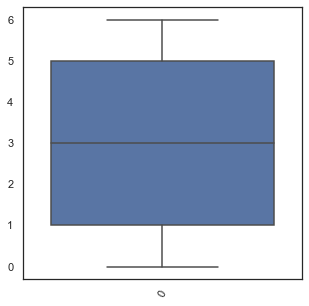

In [10]:
#I checked the hackathons column for outliers.
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
sns.boxplot(data=df["hackathons"], ax=ax)

In [11]:
Q1 = df["hackathons"].quantile(0.25)
Q3 = df["hackathons"].quantile(0.75)
IQR = Q3-Q1
low_lim = Q1- 1.5*IQR
up_lim = Q3 + 1.5*IQR
outlier = ((df["hackathons"]<low_lim) | (df["hackathons"]>up_lim))

In [12]:
df["hackathons"][outlier] #This column hasn't any outlier

Series([], Name: hackathons, dtype: int64)

<AxesSubplot:>

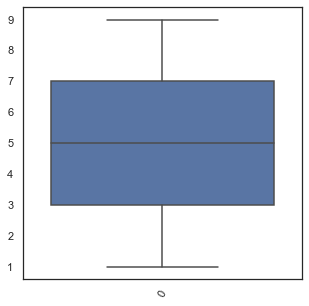

In [13]:
#I checked the coding skills rating column for outliers.
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
sns.boxplot(data=df["coding skills rating"], ax=ax)

In [14]:
Q1 = df["coding skills rating"].quantile(0.25)
Q3 = df["coding skills rating"].quantile(0.75)
IQR = Q3-Q1
low_lim = Q1- 1.5*IQR
up_lim = Q3 + 1.5*IQR
outlier = ((df["coding skills rating"]<low_lim) | (df["coding skills rating"]>up_lim))

In [15]:
df["coding skills rating"][outlier] #This column hasn't any outlier

Series([], Name: coding skills rating, dtype: int64)

<AxesSubplot:>

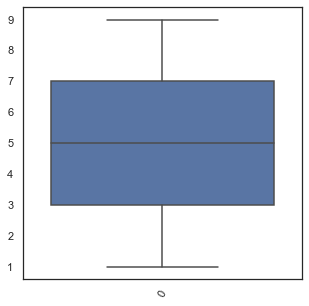

In [16]:
#I checked the public speaking points column for outliers.
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
sns.boxplot(data=df["coding skills rating"], ax=ax)

In [17]:
Q1 = df["public speaking points"].quantile(0.25)
Q3 = df["public speaking points"].quantile(0.75)
IQR = Q3-Q1
low_lim = Q1- 1.5*IQR
up_lim = Q3 + 1.5*IQR
outlier = ((df["public speaking points"]<low_lim) | (df["public speaking points"]>up_lim))

In [18]:
df["public speaking points"][outlier] #This column hasn't any outlier

Series([], Name: public speaking points, dtype: int64)

In [19]:
print("\nList of Categorical features: \n" , df.select_dtypes(include=['object']).columns.tolist())


List of Categorical features: 
 ['self-learning capability?', 'Extra-courses did', 'certifications', 'workshops', 'reading and writing skills', 'memory capability score', 'Interested subjects', 'interested career area ', 'Type of company want to settle in?', 'Taken inputs from seniors or elders', 'Interested Type of Books', 'Management or Technical', 'hard/smart worker', 'worked in teams ever?', 'Introvert', 'Suggested Job Role']


In [20]:
categorical_col = df[['self-learning capability?', 'Extra-courses did','reading and writing skills', 'memory capability score',
                      'Taken inputs from seniors or elders', 'Management or Technical', 'hard/smart worker', 'worked in teams ever?',
                      'Introvert', 'interested career area ']]
for i in categorical_col:
    print(df[i].value_counts(), end="\n\n")

yes    3496
no     3405
Name: self-learning capability?, dtype: int64

no     3529
yes    3372
Name: Extra-courses did, dtype: int64

excellent    2328
medium       2315
poor         2258
Name: reading and writing skills, dtype: int64

medium       2317
excellent    2303
poor         2281
Name: memory capability score, dtype: int64

yes    3501
no     3400
Name: Taken inputs from seniors or elders, dtype: int64

Management    3461
Technical     3440
Name: Management or Technical, dtype: int64

smart worker    3523
hard worker     3378
Name: hard/smart worker, dtype: int64

no     3470
yes    3431
Name: worked in teams ever?, dtype: int64

yes    3544
no     3357
Name: Introvert, dtype: int64

system developer            1178
security                    1177
Business process analyst    1154
developer                   1145
testing                     1128
cloud computing             1119
Name: interested career area , dtype: int64



In [21]:
# Changing the categorical values to numerical values
cols = df[["self-learning capability?", "Extra-courses did","Taken inputs from seniors or elders", "worked in teams ever?", "Introvert"]]
for i in cols:
    cleanup_nums = {i: {"yes": 1, "no": 0}}
    df = df.replace(cleanup_nums)

In [22]:
mycol = df[["reading and writing skills", "memory capability score"]]
for i in mycol:
    cleanup_nums = {i: {"poor": 0, "medium": 1, "excellent": 2}}
    df = df.replace(cleanup_nums)

category_cols = df[['certifications', 'workshops', 'Interested subjects', 'interested career area ', 'Type of company want to settle in?',
                    'Interested Type of Books']]
for i in category_cols:
    df[i] = df[i].astype('category')
    df[i] = df[i].cat.codes

list = {"Management":0, "Technical":1, "hard worker":0, "smart worker":1}
df = df.replace(list)

In [23]:

df.head()

,Logical quotient rating,hackathons,coding skills rating,public speaking points,self-learning capability?,Extra-courses did,certifications,workshops,reading and writing skills,memory capability score,Interested subjects,interested career area,Type of company want to settle in?,Taken inputs from seniors or elders,Interested Type of Books,Management or Technical,hard/smart worker,worked in teams ever?,Introvert,Suggested Job Role
0,5,0,6,2,1,0,4,6,0,0,9,5,0,0,28,0,1,1,0,Applications Developer
1,7,6,4,3,0,1,8,6,2,1,2,4,1,1,3,1,0,0,1,Applications Developer
2,2,3,9,1,0,1,4,6,2,0,5,0,9,1,29,1,1,0,0,Applications Developer
3,2,6,3,5,0,1,7,2,2,0,7,5,7,1,13,0,1,1,1,Applications Developer
4,2,0,3,4,1,0,1,3,2,1,3,4,0,0,14,1,0,1,0,Applications Developer


<AxesSubplot:>

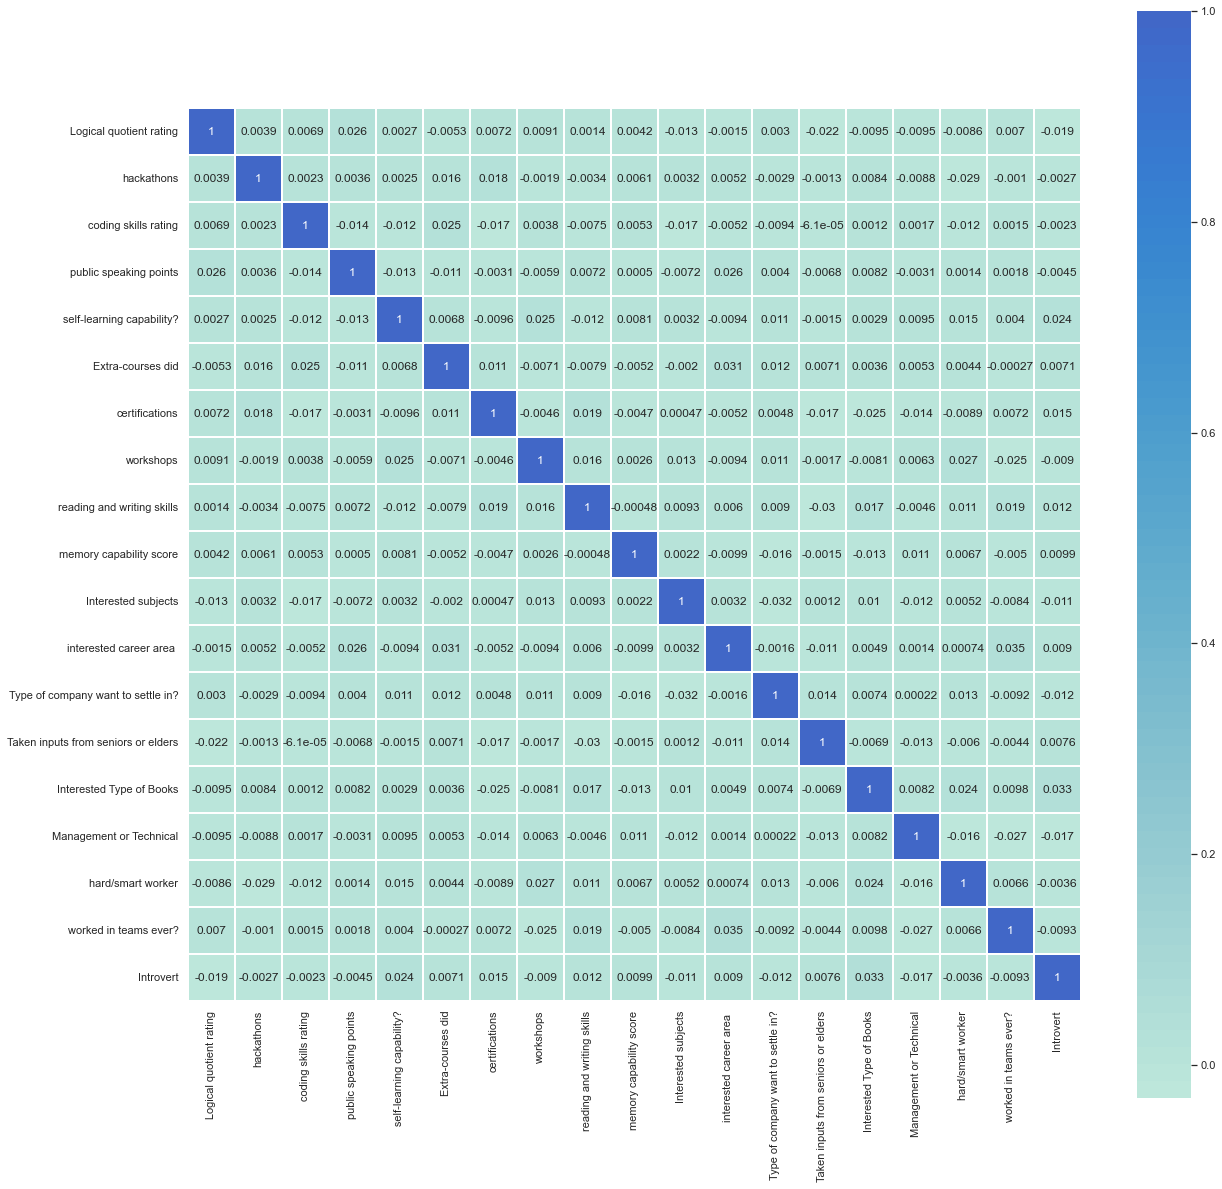

In [24]:
df3 = df.drop(columns = ["Suggested Job Role"])
df3 = df3.corr()
f,axes = plt.subplots(1,1,figsize = (20,20))
sns.heatmap(df3,square=True,annot = True,linewidth = .4,center = 2,ax = axes)

No highly corelated numerical pair found.

In [25]:
pca = PCA()
pca.fit(df3)
PC_components = np.arange(pca.n_components_) + 1

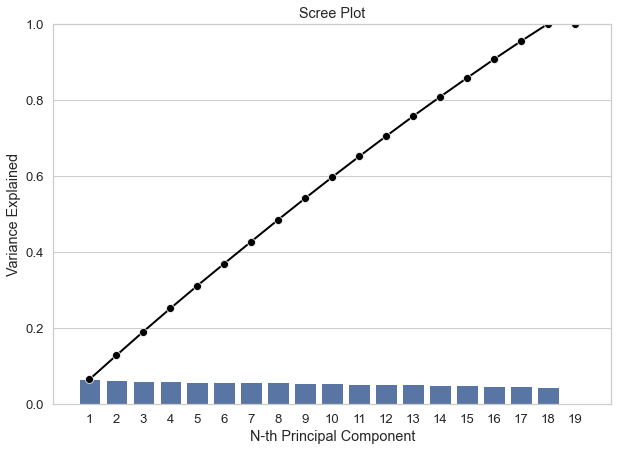

In [26]:
# Scree Plot
_ = sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.barplot(x=PC_components, y=pca.explained_variance_ratio_, color='b')
_ = sns.lineplot(x=PC_components-1, y=np.cumsum(pca.explained_variance_ratio_), color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()
#As you see after 18 feature relation, there is no change in data explainability.
#Which means we can use 18 feature to explain our data.

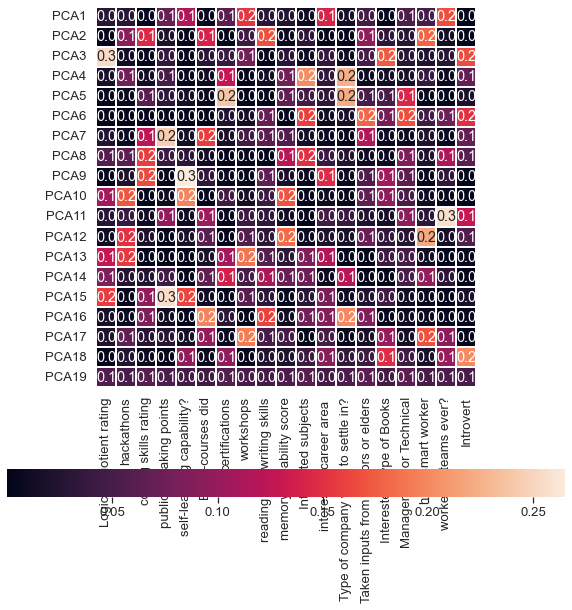

In [27]:
# Feature Weight
fig, ax = plt.subplots(figsize=(10,10))
_ = sns.heatmap(pca.components_**2,
                yticklabels=["PCA"+str(x) for x in range(1,pca.n_components_+1)],
                xticklabels=(df3.columns),
                ax = ax,
                annot=True,
                fmt='.1f',
                square=True,
                linewidths=0.05,
                cbar_kws={"orientation": "horizontal"})

In [28]:
#So, we can re-run the PCA model, but this time with the n_components=18 argument, which tells the PCA to keep only the top 18 principal components for us.

In [29]:
pca = PCA(n_components=18)

In [30]:
pca.fit(df3)
PC_components = np.arange(pca.n_components_) + 1

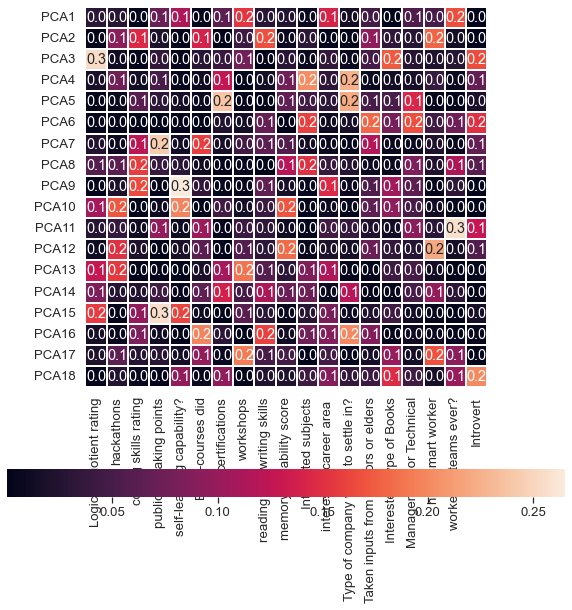

In [31]:
# Feature Weight
fig, ax = plt.subplots(figsize=(10,10))
_ = sns.heatmap(pca.components_**2,
                yticklabels=["PCA"+str(x) for x in range(1,pca.n_components_+1)],
                xticklabels=(df3.columns),
                ax = ax,
                annot=True,
                fmt='.1f',
                square=True,
                linewidths=0.05,
                cbar_kws={"orientation": "horizontal"})    #9-10-9-8-9-9-9-7-9-11-9-9-6-7-8-8-7-7-7-9-11

In [32]:
#As you can see the heatmap above, PCA raws associate with 18 columns of data. It means that we can reduce the dimension of data to 17 columns with dropping interested career are column.

In [33]:
df = df.drop(columns = ["interested career area "])

In [34]:
df.head()

,Logical quotient rating,hackathons,coding skills rating,public speaking points,self-learning capability?,Extra-courses did,certifications,workshops,reading and writing skills,memory capability score,Interested subjects,Type of company want to settle in?,Taken inputs from seniors or elders,Interested Type of Books,Management or Technical,hard/smart worker,worked in teams ever?,Introvert,Suggested Job Role
0,5,0,6,2,1,0,4,6,0,0,9,0,0,28,0,1,1,0,Applications Developer
1,7,6,4,3,0,1,8,6,2,1,2,1,1,3,1,0,0,1,Applications Developer
2,2,3,9,1,0,1,4,6,2,0,5,9,1,29,1,1,0,0,Applications Developer
3,2,6,3,5,0,1,7,2,2,0,7,7,1,13,0,1,1,1,Applications Developer
4,2,0,3,4,1,0,1,3,2,1,3,0,0,14,1,0,1,0,Applications Developer


<AxesSubplot:xlabel='Suggested Job Role', ylabel='count'>

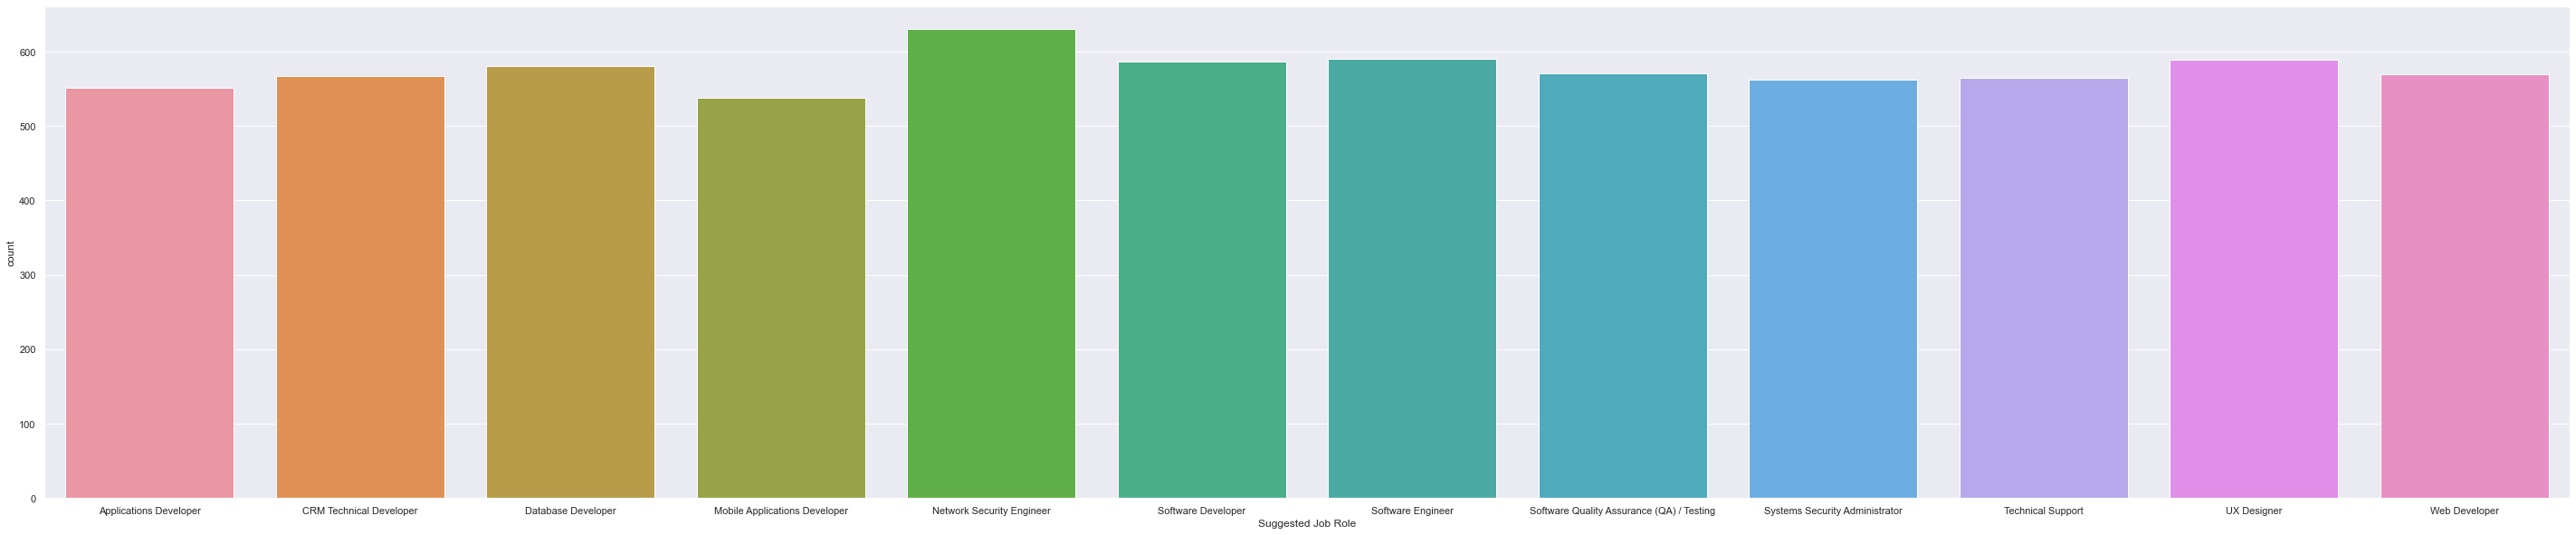

In [35]:
# Checking for data imbalanceness if any
sns.set(rc={'figure.figsize':(50,10)})
sns.countplot(x = df["Suggested Job Role"])